In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import math
from datetime import datetime
from datetime import timedelta
import pytz

path = '/Users/artemilin/Downloads/data'

In [3]:
companies_of_choice = ['AAPL.csv',  ## Apple
                       'AMZN.csv',  ## Amazon
                       'FB.csv',  ## Facebook (now META)
                       'GOOGL.csv',  ## Google Alphabet Inc.
                       'MSFT.csv',  ## Microsoft
                       'NFLX.csv',  ## Netflix
                       'NVDA.csv',  ## Nvidia
                       'TSLA.csv'  ## Tesla
                       ]

In [4]:
all_dfs = []
shapes_of_tickers_dfs = {}

for ticker in companies_of_choice:
    dirs = []
    for year in ['2017', '2018', '2019', '2021']:
        dirs.append(f'{path}/{year}/{ticker}')

    df_ticker = pd.concat(
        map(pd.read_csv, dirs), ignore_index=True)
    #df_ticker['date'] = pd.to_datetime(df_ticker['date'])
    shapes_of_tickers_dfs[ticker] = df_ticker.shape

    all_dfs.append(df_ticker.add_prefix(f'{ticker.split(".")[0]}_'))

df0 = pd.concat(all_dfs, axis=1)

In [83]:
df0.head()

,AAPL_date,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,AAPL_vwap,AAPL_timestamp,AAPL_transactions,AAPL_otc,...,TSLA_date,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,TSLA_vwap,TSLA_timestamp,TSLA_transactions,TSLA_otc
0,2017-01-03 09:30:00-05:00,28.9500,28.9750,28.8750,28.9713,3851984.0,28.9422,1483453800000,1970.0,NaN,...,2017-01-03 09:30:00-05:00,14.3240,14.3533,14.2800,14.2840,1360425.0,14.3219,1.483454e+12,367.0,NaN
1,2017-01-03 09:31:00-05:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1483453860000,1050.0,NaN,...,2017-01-03 09:31:00-05:00,14.2800,14.2987,14.2500,14.2500,756270.0,14.2741,1.483454e+12,497.0,NaN
2,2017-01-03 09:32:00-05:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,1483453920000,700.0,NaN,...,2017-01-03 09:32:00-05:00,14.2500,14.2500,14.1720,14.1893,702690.0,14.2128,1.483454e+12,550.0,NaN
3,2017-01-03 09:33:00-05:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1483453980000,1049.0,NaN,...,2017-01-03 09:33:00-05:00,14.1853,14.2020,14.0913,14.1000,1084935.0,14.1462,1.483454e+12,599.0,NaN
4,2017-01-03 09:34:00-05:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,1483454040000,929.0,NaN,...,2017-01-03 09:34:00-05:00,14.0933,14.1253,14.0640,14.1193,1251645.0,14.0868,1.483454e+12,689.0,NaN


In [5]:
df_AAPL = df0[['AAPL_date', 'AAPL_open', 'AAPL_high', 'AAPL_low', 'AAPL_close', 'AAPL_volume', 'AAPL_vwap',
              'AAPL_transactions']]  # 'AAPL_timestamp',

df_AAPL = df_AAPL.rename(columns={"AAPL_date": "date",
                                  "AAPL_open": "open",
                                  "AAPL_high": "high",
                                  "AAPL_low": "low",
                                  "AAPL_close": "close",
                                  "AAPL_volume": "volume",
                                  "AAPL_vwap": "vwap",
                                  "AAPL_transactions": "transactions"
                                  })

df_AAPL['date'] = pd.to_datetime(df_AAPL['date'], format="%Y-%m-%d %H:%M:%S", utc=True)
df_AAPL = df_AAPL.set_index(pd.DatetimeIndex(df_AAPL['date']))

In [85]:
day_df = df_AAPL.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
day_df = day_df[~day_df['close'].isna()]

In [58]:
day_df.head()

,open,high,low,close,volume
date,,,,,
2017-01-03 00:00:00+00:00,28.9500,29.0825,28.6900,29.0225,102572716.0
2017-01-04 00:00:00+00:00,28.9625,29.1275,28.9375,29.0025,74946512.0
2017-01-05 00:00:00+00:00,28.9800,29.2161,28.9525,29.1525,83368768.0
2017-01-06 00:00:00+00:00,29.1950,29.5400,29.1175,29.4925,116451676.0
2017-01-09 00:00:00+00:00,29.4875,29.8575,29.4850,29.7450,122837968.0


In [6]:
df_AAPL['log_price'] = np.log(df_AAPL['close'])

In [7]:
df_AAPL["rets"] = df_AAPL["close"].pct_change()

In [8]:
vols = df_AAPL["rets"].rolling(60).std(ddof=0)
df_AAPL['r_vol'] = pd.DataFrame(vols)
df_AAPL['r_vol'].fillna((df_AAPL['r_vol'].mean()), inplace=True)

In [9]:
df_AAPL = df_AAPL.iloc[1:]

In [16]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series/100).cumprod()
    previous_peaks = np.log(wealth_index.cummax())
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})

drawdown(df_AAPL['close'])["Previous Peak"] - Becomes inf => drawdowns besomes 0 and NaNs, don't try this at home

In [63]:
df_AAPL.head()

,date,open,high,low,close,volume,vwap,transactions,log_price,rets,r_vol
date,,,,,,,,,,,
2017-01-03 14:31:00+00:00,2017-01-03 14:31:00+00:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677
2017-01-03 14:32:00+00:00,2017-01-03 14:32:00+00:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677
2017-01-03 14:33:00+00:00,2017-01-03 14:33:00+00:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677
2017-01-03 14:34:00+00:00,2017-01-03 14:34:00+00:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677
2017-01-03 14:35:00+00:00,2017-01-03 14:35:00+00:00,29.0375,29.0625,29.0200,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677


In [10]:
df_AAPL = df_AAPL.dropna()
df_AAPL["OBV"] = (np.sign(df_AAPL["close"].diff()) * df_AAPL["volume"]).fillna(0).cumsum()

In [11]:
exp1 = df_AAPL['close'].ewm(span=12, adjust=False).mean()
exp2 = df_AAPL['close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
df_AAPL['MACD'] = macd

In [14]:
def compute_volume_bars(df, volume_bar_size):
    cumsum_vol = df['volume'].cumsum()/volume_bar_size
    max_tick = int(cumsum_vol.max())
    ticks = pd.Series(range(max_tick))
    return cumsum_vol.searchsorted(ticks)

In [ ]:
# df_AAPL['volume_bars'] = compute_volume_bars(df_AAPL, 4)

In [ ]:
def compute_dollar_bars(df, dollar_bar_size):
    '''
        Compute indexes of dollar bars, indexes represented as integers,
        data can be fetched by df.iloc[idxs]
    '''
    if 'vwap' in df.columns:
        dollars = df['volume'] * df['vwap']
    else:
        dollars = (df['close'] + df['open'])/2 * df['volume']
    dollars = dollars.cumsum()/dollar_bar_size
    max_tick = int(dollars.max())
    ticks = pd.Series(range(max_tick))
    return dollars.searchsorted(ticks)

In [ ]:
## df_AAPL['dollar_bars'] = compute_dollar_bars(df_AAPL, 4)

In [12]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [13]:
df_AAPL['rsi'] = rsi(df_AAPL, periods = 60, ema = True)

In [14]:
df_AAPL = df_AAPL.apply(lambda x: x.fillna(x.mean()),axis=0)

In [15]:
def bollinger_bands(df, n=60, m=60):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA

    #typical price
    TP = (df['high'] + df['low'] + df['close']) / 3
    # but we will use Adj close instead for now, depends

    data = TP
    #data = df['Adj Close']

    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std()

    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')

    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)

    return df

In [16]:
df_AAPL = bollinger_bands(df_AAPL)

In [17]:
df_AAPL = df_AAPL.apply(lambda x: x.fillna(x.mean()), axis=0)

In [18]:
df_AAPL

,date,open,high,low,close,volume,vwap,transactions,log_price,rets,r_vol,OBV,MACD,rsi,B_MA,BU,BL
date,,,,,,,,,,,,,,,,,
2017-01-03 14:31:00+00:00,2017-01-03 14:31:00+00:00,28.9750,29.0625,28.9475,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677,0.000000e+00,0.000000,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:32:00+00:00,2017-01-03 14:32:00+00:00,29.0625,29.0825,29.0575,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677,6.534080e+05,0.001021,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:33:00+00:00,2017-01-03 14:33:00+00:00,29.0750,29.0750,29.0050,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677,-3.521840e+05,-0.001972,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:34:00+00:00,2017-01-03 14:34:00+00:00,29.0273,29.0600,29.0273,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677,3.155760e+05,-0.003504,50.775145,57.951917,65.468024,50.435810
2017-01-03 14:35:00+00:00,2017-01-03 14:35:00+00:00,29.0375,29.0625,29.0200,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677,3.155760e+05,-0.004665,50.775145,57.951917,65.468024,50.435810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 20:56:00+00:00,2020-12-31 20:56:00+00:00,132.6500,132.8200,132.6500,132.7693,513816.0,132.7459,3191.0,4.888613,0.000975,0.000944,2.448501e+09,0.009497,49.985376,132.860787,142.346972,123.374601
2020-12-31 20:57:00+00:00,2020-12-31 20:57:00+00:00,132.7700,132.9200,132.7600,132.8408,505929.0,132.8310,3527.0,4.889151,0.000539,0.000946,2.449007e+09,0.010779,50.856946,132.858958,142.320223,123.397693
2020-12-31 20:58:00+00:00,2020-12-31 20:58:00+00:00,132.8400,132.9200,132.8300,132.8600,517398.0,132.8745,3472.0,4.889296,0.000145,0.000946,2.449525e+09,0.013192,51.089702,132.857902,142.301491,123.414314


In [21]:
df_AAPL.to_csv('AAPLFeatures.csv', index=False)

In [3]:
df = pd.read_csv('AAPLFeatures.csv').drop(columns=['open', 'high', 'low', 'OBV', 'BU', 'BL'])

In [4]:
df.head()

,date,close,volume,vwap,transactions,log_price,rets,r_vol,MACD,rsi,B_MA
0,2017-01-03 14:31:00+00:00,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677,0.000000,50.775145,57.951917
1,2017-01-03 14:32:00+00:00,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677,0.001021,50.775145,57.951917
2,2017-01-03 14:33:00+00:00,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677,-0.001972,50.775145,57.951917
3,2017-01-03 14:34:00+00:00,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677,-0.003504,50.775145,57.951917
4,2017-01-03 14:35:00+00:00,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677,-0.004665,50.775145,57.951917


Text(0, 0.5, '$Price')

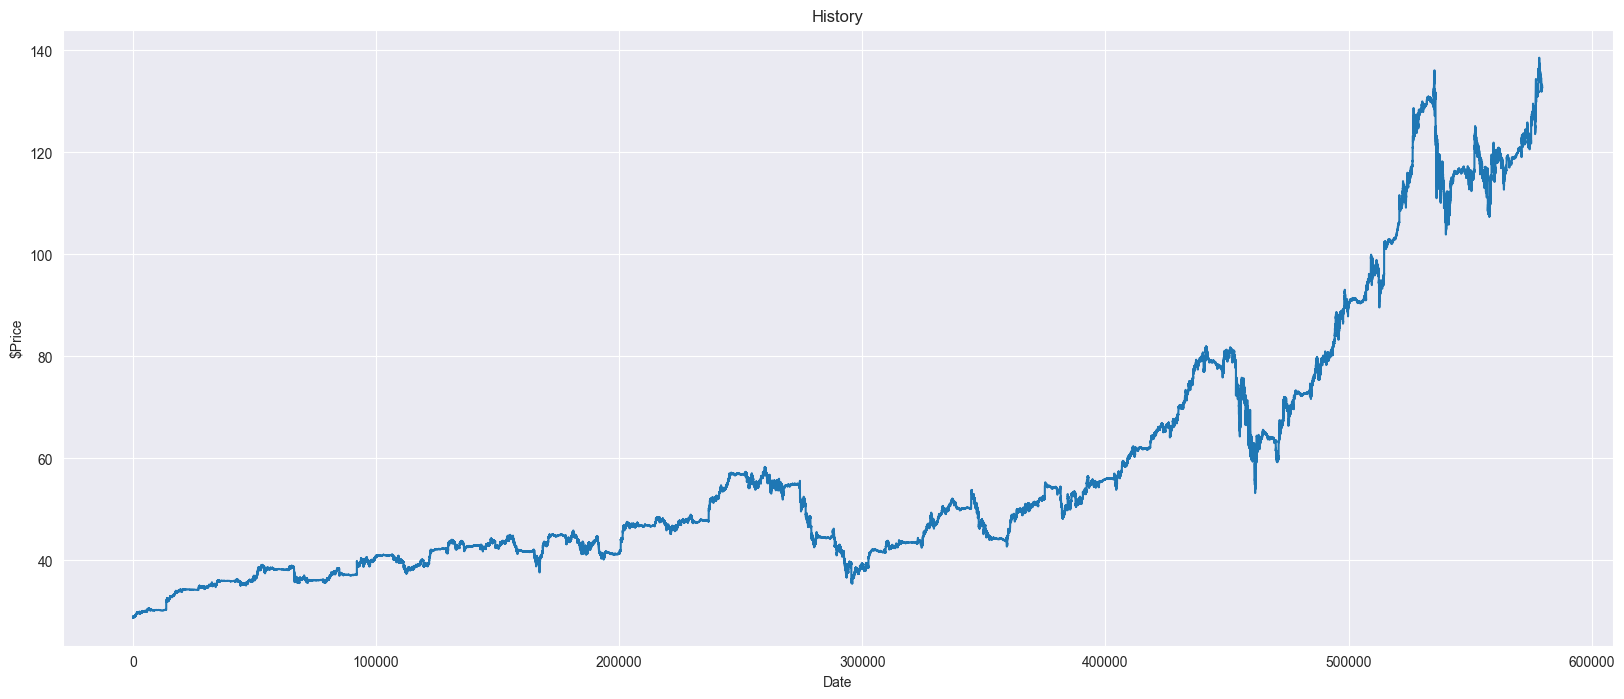

In [7]:
plt.figure(figsize=(20, 8))
plt.title('History')
plt.plot(df_AAPL[['close']])
plt.xlabel('Date')
plt.ylabel('$Price')

https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

In [12]:
us_tz = pytz.timezone('Us/Eastern')

start = datetime.strptime("2017-01-03 09:30:00", "%Y-%m-%d %H:%M:%S")
end = datetime.strptime("2018-01-03 09:30:00", "%Y-%m-%d %H:%M:%S")

slice_df = df[(df['date'] > str(start)) & (df['date'] < str(end))]

In [20]:
df_train = slice_df.loc[slice_df["date"]<"2017-09-01"]
df_test  = slice_df.loc[slice_df["date"]>="2017-09-01"]

In [25]:
print(df_train.shape)
print(df_test.shape)

(106561, 11)
(44395, 11)


In [27]:
slice_df.columns

Index(['date', 'close', 'volume', 'vwap', 'transactions', 'log_price', 'rets',
       'r_vol', 'MACD', 'rsi', 'B_MA'],
      dtype='object')

In [31]:
slice_df = slice_df.rename(columns={"date": "ds", "close": "y"})

In [33]:
slice_df.head()

,ds,y,volume,vwap,transactions,log_price,rets,r_vol,MACD,rsi,B_MA
0,2017-01-03 14:31:00+00:00,29.0622,997416.0,29.0088,1050.0,3.369438,0.003138,0.000677,0.000000,50.775145,57.951917
1,2017-01-03 14:32:00+00:00,29.0750,653408.0,29.0686,700.0,3.369879,0.000440,0.000677,0.001021,50.775145,57.951917
2,2017-01-03 14:33:00+00:00,29.0276,1005592.0,29.0285,1049.0,3.368247,-0.001630,0.000677,-0.001972,50.775145,57.951917
3,2017-01-03 14:34:00+00:00,29.0375,667760.0,29.0412,929.0,3.368588,0.000341,0.000677,-0.003504,50.775145,57.951917
4,2017-01-03 14:35:00+00:00,29.0375,779004.0,29.0435,1434.0,3.368588,0.000000,0.000677,-0.004665,50.775145,57.951917


In [35]:
slice_df.columns

Index(['ds', 'y', 'volume', 'vwap', 'transactions', 'log_price', 'rets',
       'r_vol', 'MACD', 'rsi', 'B_MA'],
      dtype='object')

In [44]:
slice_df['ds'] = pd.to_datetime(slice_df['ds'])
type(slice_df['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [51]:
slice_df['ds'] = pd.to_datetime(slice_df['ds'] , format='%d/%m/%y %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')

In [56]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=0.01)
for feature in ['volume', 'vwap', 'transactions', 'log_price', 'rets', 'r_vol', 'MACD', 'rsi', 'B_MA']:
    m.add_regressor(feature)

In [57]:
m.fit(df_train)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
"""model.compile(optimizer='adam', loss='mean_absolute_percentage_error')  ###
model.fit(x_train, y_train, batch_size=1, epochs=3)"""